## Recommender System

#### Background on the approach

We use a matrix factorization approach, one of the most commonly used techniques for recommender systems. 
I used a stochastic gradient descent algorithm to optimize the matrices p and q, representing the users with their 
latent factors and the movies with their latent factors.

#### Description of the model

The matrix factorization model assumes that the decision for a user's rating of a movie is based on 
(unknown) latent factors that describe the movie and that describe the person. We assume that each user can be 
represented by a vector of x latent factors, and so can the movie. We dot product those vectors to determine 
what the score of that guess could be.

#### Description of the inference / training algorithm you use

We used stochastic gradient descent. Rather than sampling all of the data and taking a step, or even taking a 
subset of 30 data points, we train on one data point, then update p's, q's, and b's.

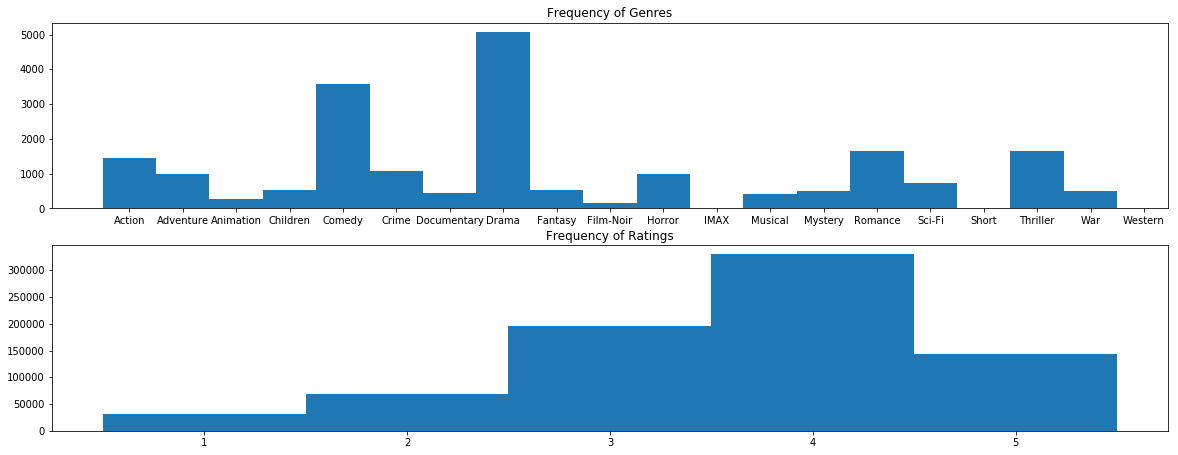

In [0]:
import matplotlib.pyplot as plt
import seaborn
import pandas
import numpy as np
 
ur = pandas.read_csv(r'C:\Users\Public\Documents\Anaconda\movie_training_data\user_ratedmovies_train.dat','\t')
mg = pandas.read_csv(r'C:\Users\Public\Documents\Anaconda\movie_training_data\movie_genres.dat','\t')

fig, axs = plt.subplots(2, 1, figsize=(20, 7.5))
genre_bins = 20
rating_bins = 7
axs[0].hist( mg['genre'], bins=np.arange(genre_bins)-0.5)
axs[1].hist( ur['rating'], bins=np.arange(rating_bins)[1:]-0.5)
axs[0].set_title('Frequency of Genres')
axs[1].set_title('Frequency of Ratings')
plt.show()

# create a test/train split
all_inds = np.random.permutation( range(0,len(ur)) )
test_inds = all_inds[0:85000]
train_inds = all_inds[85000:len(ur)]
 
ur_test = ur.iloc[ test_inds ]
ur_train = ur.iloc[ train_inds ]

In [0]:
import time

LEARN_RATE = .5
NUM_FACTORS = 2
NUM_ITERS = 5
NUM_MOVIES = 10197
NUM_USERS = 2113

def create_dict(ids):
    hash_val = 0
    sorted_ids = np.sort(ids, kind='quicksort')
    set_of_ids = []
    set_of_ids.append(sorted_ids[0])
    for i in range(len(ids)):
        if (sorted_ids[i] != set_of_ids[-1]):
            set_of_ids.append(sorted_ids[i])
            hash_val += 1
    hash_vals = {}
    for i in range(len(set_of_ids)):
        hash_vals[set_of_ids[i]] = i
    return hash_vals

def fill_true_ratings(ur_train, user_dict, movie_dict):
    true_ratings = np.empty((NUM_USERS, NUM_MOVIES))
    true_ratings[:] = np.nan
    for i in range(len(ur['rating'])):
        if (i in ur_train['userID']):
            user = user_dict[ur_train['userID'][i]]
            movie = movie_dict[ur_train['movieID'][i]]
            rating = ur_train['rating'][i]
            true_ratings[user][movie] = rating
    return true_ratings

def watched(user, movie):
    if (np.isnan(true_ratings[user][movie])):
        return False
    else:
        return True
    
#Creates a dictionary mapping userID's to hash_values 0-2112
user_dict = create_dict(ur['userID'])
movie_dict = create_dict(ur['movieID'])

#Creates a matrix of known ratings with re-hashed movie id's and user id's
true_ratings = fill_true_ratings(ur_train, user_dict, movie_dict)

In [0]:
def update_p_q(user, movie, rating, pu, qi, bu, bi, mu):
    rho_ui = (mu + bi + bu + np.dot(pu, qi)) - rating
    pu = (1 - LAMBDA*LEARN_RATE)*pu - LEARN_RATE*qi*rho_ui
    qi = (1 - LAMBDA*LEARN_RATE)*qi - LEARN_RATE*pu*rho_ui
    bu = (1 - LAMBDA*LEARN_RATE)*bu - LEARN_RATE*rho_ui
    bi = (1 - LAMBDA*LEARN_RATE)*bi - LEARN_RATE*rho_ui
    mu = (1 - LAMBDA*LEARN_RATE)*mu - LEARN_RATE*rho_ui
    return pu, qi, bu, bi, mu

def calc_rmse(p, q, test_user_ids, test_movie_ids):
    prediction_matrix = np.dot(p,q)
    predictions = np.zeros(len(modded_user_ids))
    for i in range(len(modded_user_ids)):
        predictions[i] = prediction_matrix[user_dict[test_user_ids[i]]][movie_dict[test_movie_ids[i]]]
    rmse = np.sqrt(1/85000*np.sum((predictions - np_test_ratings)**2))
    return rmse

## Trial 1: 600,000 iterations, Latent Factors = 4, Lambda = .02,  Learn_Rate = .05

6.0 Minutes Elapsed


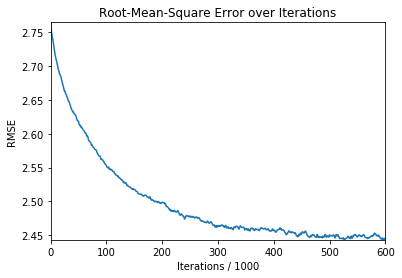

In [0]:
num_users = len(user_dict)
num_movies = len(movie_dict)
ITERS = 600000
LAMBDA = .02
LEARN_RATE = .05
NUM_FACTORS = 4

avg_rating = np.average(ur_train['rating'])
guess = np.sqrt(avg_rating)/4

p = np.zeros((NUM_USERS, NUM_FACTORS)) + guess
q = np.zeros((NUM_FACTORS, NUM_MOVIES)) + guess
b_u = np.zeros(num_users) + .02    #Initial guess for user bias
b_i = np.zeros(num_movies) + .02   #Initial guess for movie bias
mu = np.random.uniform(0, 1)

start = time.time()

np_test_user_ids = ur_test['userID'].values
np_test_movie_ids = ur_test['movieID'].values
np_test_ratings = ur_test['rating'].values

rmse = []
for iters in range(ITERS):
    user = np.random.randint(0, num_users - 1)
    movie = np.random.randint(0, num_movies - 1)
    while(not watched(user,movie)):
        user = np.random.randint(0, num_users - 1)
        movie = np.random.randint(0, num_movies - 1)
    pu = p[user,:]
    qi = q[:, movie]
    rating = true_ratings[user][movie]
    #print(user, movie, rating, pu, qi, b_u[user], b_i[movie], mu)
    p[user,:], q[:,movie], b_u[user], b_i[movie], mu = update_p_q(user, movie, rating, pu, qi, b_u[user], b_i[movie], mu)
    if (iters % 1000 == 0):
        rmse.append(calc_rmse(p, q, np_test_user_ids, np_test_movie_ids))
        #print("RMSE:", rmse[iters // 1000])
        #print(iters//ITERS * 100, "%")
        
end = time.time()
print((end - start) // 60, "Minutes Elapsed")

plt.plot(np.arange(len(rmse)), rmse)
plt.xlabel('Iterations / 1000')
plt.ylabel('RMSE')
plt.title('Root-Mean-Square Error over Iterations')
plt.axis([0, ITERS // 1000, min(rmse), max(rmse)])
plt.show()

## Trial 2: 400,000 iterations, Lambda = .02, Learn_Rate = .05

4.0 Minutes Elapsed


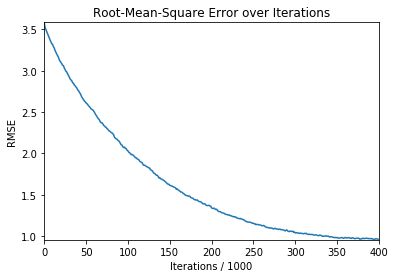

In [0]:
num_users = len(user_dict)
num_movies = len(movie_dict)
ITERS = 400000
LAMBDA = .02
LEARN_RATE = .05
NUM_FACTORS = 2

avg_rating = np.average(ur_train['rating'])
guess = np.sqrt(avg_rating)

p = np.zeros((NUM_USERS, NUM_FACTORS)) + guess
q = np.zeros((NUM_FACTORS, NUM_MOVIES)) + guess
b_u = np.zeros(num_users) + .02    #Initial guess for user bias
b_i = np.zeros(num_movies) + .02   #Initial guess for movie bias
mu = np.random.uniform(0, 1)

start = time.time()


np_test_user_ids = ur_test['userID'].values
np_test_movie_ids = ur_test['movieID'].values
np_test_ratings = ur_test['rating'].values

rmse = []
for iters in range(ITERS):
    user = np.random.randint(0, num_users - 1)
    movie = np.random.randint(0, num_movies - 1)
    while(not watched(user,movie)):
        user = np.random.randint(0, num_users - 1)
        movie = np.random.randint(0, num_movies - 1)
    pu = p[user,:]
    qi = q[:, movie]
    rating = true_ratings[user][movie]
    #print(user, movie, rating, pu, qi, b_u[user], b_i[movie], mu)
    p[user,:], q[:,movie], b_u[user], b_i[movie], mu = update_p_q(user, movie, rating, pu, qi, b_u[user], b_i[movie], mu)
    if (iters % 1000 == 0):
        rmse.append(calc_rmse(p, q, np_test_user_ids, np_test_movie_ids))
        #print("RMSE:", rmse[iters // 1000])
        
end = time.time()
print((end - start) // 60, "Minutes Elapsed")

plt.plot(np.arange(len(rmse)), rmse)
plt.xlabel('Iterations / 1000')
plt.ylabel('RMSE')
plt.title('Root-Mean-Square Error over Iterations')
plt.axis([0, ITERS // 1000, min(rmse), max(rmse)])
plt.show()

## Trial 3: 600,000 Iterations, Latent Factors = 2, Lambda = .03, Learn_Rate = .001

6.0 Minutes Elapsed


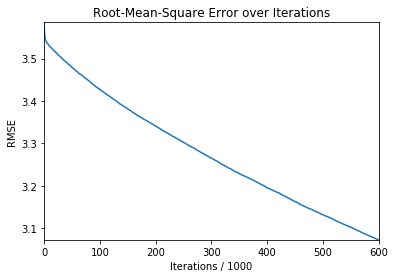

In [0]:
num_users = len(user_dict)
num_movies = len(movie_dict)
ITERS = 600000
LAMBDA = .03
LEARN_RATE = .001
NUM_FACTORS = 2

avg_rating = np.average(ur_train['rating'])
guess = np.sqrt(avg_rating)

p = np.zeros((NUM_USERS, NUM_FACTORS)) + guess
q = np.zeros((NUM_FACTORS, NUM_MOVIES)) + guess
b_u = np.zeros(num_users) + .02    #Initial guess for user bias
b_i = np.zeros(num_movies) + .02   #Initial guess for movie bias
mu = np.random.uniform(0, 1)

start = time.time()


np_test_user_ids = ur_test['userID'].values
np_test_movie_ids = ur_test['movieID'].values
np_test_ratings = ur_test['rating'].values

rmse = []
for iters in range(ITERS):
    user = np.random.randint(0, num_users - 1)
    movie = np.random.randint(0, num_movies - 1)
    while(not watched(user,movie)):
        user = np.random.randint(0, num_users - 1)
        movie = np.random.randint(0, num_movies - 1)
    pu = p[user,:]
    qi = q[:, movie]
    rating = true_ratings[user][movie]
    #print(user, movie, rating, pu, qi, b_u[user], b_i[movie], mu)
    p[user,:], q[:,movie], b_u[user], b_i[movie], mu = update_p_q(user, movie, rating, pu, qi, b_u[user], b_i[movie], mu)
    if (iters % 1000 == 0):
        rmse.append(calc_rmse(p, q, np_test_user_ids, np_test_movie_ids))
        #print("RMSE:", rmse[iters // 1000])
        
end = time.time()
print((end - start) // 60, "Minutes Elapsed")

plt.plot(np.arange(len(rmse)), rmse)
plt.xlabel('Iterations / 1000')
plt.ylabel('RMSE')
plt.title('Root-Mean-Square Error over Iterations')
plt.axis([0, ITERS // 1000, min(rmse), max(rmse)])
plt.show()

[ 3.16774677  2.20185097  3.08989169  2.52805541  2.16465804]


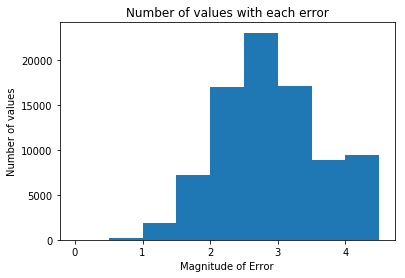

In [0]:
prediction_matrix = np.dot(p,q)
predictions = np.zeros(len(modded_user_ids))
for i in range(len(modded_user_ids)):
    predictions[i] = prediction_matrix[user_dict[np_test_user_ids[i]]][movie_dict[np_test_movie_ids[i]]]
diff = predictions - np_test_ratings
hist_bins = np.arange(0, 5, .5)
print(diff[0:5])
plt.hist(np.clip(diff, hist_bins[0], hist_bins[-1]), bins=hist_bins)
plt.title('Number of values with each error')
plt.xlabel('Magnitude of Error')
plt.ylabel('Number of values')
plt.show()

## Trial 4: 2,000,000 Iterations, Latent Factors = 2, Lambda = .03, Learn_Rate = .003

25.0 Minutes Elapsed


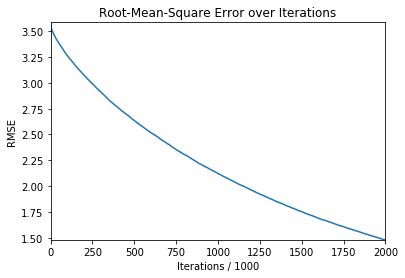

In [0]:
num_users = len(user_dict)
num_movies = len(movie_dict)
ITERS = 2000000
LAMBDA = .03
LEARN_RATE = .003
NUM_FACTORS = 2

avg_rating = np.average(ur_train['rating'])
guess = np.sqrt(avg_rating)

p = np.zeros((NUM_USERS, NUM_FACTORS)) + guess
q = np.zeros((NUM_FACTORS, NUM_MOVIES)) + guess
b_u = np.zeros(num_users) + .02    #Initial guess for user bias
b_i = np.zeros(num_movies) + .02   #Initial guess for movie bias
mu = np.random.uniform(0, 1)

start = time.time()


np_test_user_ids = ur_test['userID'].values
np_test_movie_ids = ur_test['movieID'].values
np_test_ratings = ur_test['rating'].values

rmse = []
for iters in range(ITERS):
    user = np.random.randint(0, num_users - 1)
    movie = np.random.randint(0, num_movies - 1)
    while(not watched(user,movie)):
        user = np.random.randint(0, num_users - 1)
        movie = np.random.randint(0, num_movies - 1)
    pu = p[user,:]
    qi = q[:, movie]
    rating = true_ratings[user][movie]
    #print(user, movie, rating, pu, qi, b_u[user], b_i[movie], mu)
    p[user,:], q[:,movie], b_u[user], b_i[movie], mu = update_p_q(user, movie, rating, pu, qi, b_u[user], b_i[movie], mu)
    if (iters % 1000 == 0):
        rmse.append(calc_rmse(p, q, np_test_user_ids, np_test_movie_ids))
        #print("RMSE:", rmse[iters // 1000])
        
end = time.time()
print((end - start) // 60, "Minutes Elapsed")

plt.plot(np.arange(len(rmse)), rmse)
plt.xlabel('Iterations / 1000')
plt.ylabel('RMSE')
plt.title('Root-Mean-Square Error over Iterations')
plt.axis([0, ITERS // 1000, min(rmse), max(rmse)])
plt.show()

#### Save predictions to a file

In [0]:
user_movie_pairs = pandas.read_csv(r'C:\Users\Public\Documents\Anaconda\predictions.dat','\t')
np_users = user_movie_pairs['userID'].values
np_movies = user_movie_pairs['movieID'].values

indices = np.arange(len(user_movie_pairs))
prediction_matrix = np.dot(p,q)
predictions = np.zeros(len(user_movie_pairs))
for i in range(len(user_movie_pairs)):
    if (np_movies[i] in movie_dict):
        predictions[i] = prediction_matrix[user_dict[np_users[i]]][movie_dict[np_movies[i]]]
    else:
        predictions[i] = avg_rating
pairs = np.vstack((indices, predictions))
pairs = pairs.T
np.savetxt(r"C:\Users\Public\Documents\Anaconda\learned_predictions2.csv", pairs, delimiter=",")